#### In this article we will talk about how can we use data science to understand about something about which we have hardly any idea. 

We are going to learn about ETFs and gain a genereal understanding about where to invest and which categories of ETFs we should invest in

# Importing Libraries and Dataset

Dataset Source: https://www.kaggle.com/stefanoleone992/mutual-funds-and-etfs

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df_ETF=pd.read_csv("ETFs.csv") 

In [61]:
df_ETF.shape

(2352, 104)

We have many featuers in our dataset!

In [62]:
df_ETF.head()

,fund_name,fund_extended_name,category,fund_family,net_assets,ytd_return,fund_yield,legal_type,investment,size,...,fund_sharpe_ratio_5years,category_sharpe_ratio_5years,fund_sharpe_ratio_10years,category_sharpe_ratio_10years,fund_treynor_ratio_3years,category_treynor_ratio_3years,fund_treynor_ratio_5years,category_treynor_ratio_5years,fund_treynor_ratio_10years,category_treynor_ratio_10years
0,1305,Daiwa ETF TOPIX,NaN,Daiwa Asset Management Co Ltd,4.010000e+12,NaN,1.84,Exchange Traded Fund,Blend,Large,...,0.59,NaN,0.60,NaN,3.92,NaN,8.01,NaN,9.29,NaN
1,1306,Nomura TOPIX ETF,NaN,Nomura Asset Management Co Ltd,8.430000e+12,NaN,1.77,Exchange Traded Fund,Blend,Large,...,0.59,NaN,0.61,NaN,3.94,NaN,8.03,NaN,9.33,NaN
2,1308,Nikko Exchange Traded Index TOPIX,NaN,Nikko Asset Management Co Ltd,3.730000e+12,NaN,1.84,Exchange Traded Fund,Blend,Large,...,0.59,NaN,0.60,NaN,3.93,NaN,8.03,NaN,9.31,NaN
3,1309,Nomura SSE50 Index Link ETF,NaN,Nomura Asset Management Co Ltd,4.450000e+09,NaN,0.00,Exchange Traded Fund,Value,Large,...,0.36,NaN,0.26,NaN,-4.41,NaN,6.32,NaN,4.29,NaN
4,1310,Daiwa ETF TOPIX Core 30,NaN,Daiwa Asset Management Co Ltd,1.920000e+09,NaN,2.57,Exchange Traded Fund,Blend,Large,...,0.34,NaN,0.44,NaN,1,NaN,4.08,NaN,6.18,NaN


# Data Wrangling

#### Data science -101! Machine Learning models loves numbers. Hence, lets try to understand our categorical variables.

In [63]:
for i in df_ETF.select_dtypes('object').columns:
    print(i,df_ETF[i].nunique())

fund_name 2352
fund_extended_name 2340
category 95
fund_family 174
legal_type 1
investment 3
size 3
currency 3
fund_treynor_ratio_3years 1248
category_treynor_ratio_5years 78


#### Fund Name, Family Name, Fund_extended_name won't add much value to our model, also legal type is just one value. There is no point of keeping it

##### Strangely! columns fund_treynor_ratio_3years, and category_treynor_ratio_5years are categorical variable but they look like this:

In [64]:
cols=['fund_name','fund_treynor_ratio_3years','category_treynor_ratio_5years']
df_ETF[df_ETF[cols].notnull().all(axis=1)].head()[cols]

,fund_name,fund_treynor_ratio_3years,category_treynor_ratio_5years
147,AADR,4.16,9.09
148,AAXJ,9.36,3.45
150,ACIM,10.91,10.19
151,ACSI,0,15.73
153,ACWF,9.28,10.19


#### Obviously something is wrong! Lets rectify it.

In [65]:
df_ETF['fund_treynor_ratio_3years']=df_ETF['fund_treynor_ratio_3years'].str.replace(',','').astype(float)
df_ETF['category_treynor_ratio_5years']=df_ETF['category_treynor_ratio_5years'].str.replace(',','').astype(float)

#### Taking look at the categorical variable : Currency

In [66]:
df_ETF.groupby(['currency'])['fund_extended_name'].count()

currency
EUR       2
GBP       5
USD    2345
Name: fund_extended_name, dtype: int64

#### Since there are just 7 records which are of different currency i.e around 0.2% of total records its effiecient to remove those records and then remove the currency column all together

In [67]:
search_values = ['EUR','GBP']
df_ETF.drop(df_ETF[df_ETF.currency.str.contains('|'.join(search_values ))].index, inplace= True)
# All the values are in USD. 


#### Dropping columns that I have deemed not important so far..

In [68]:
df_ETF.drop(['currency','fund_family','fund_extended_name','legal_type'], axis=1, inplace =True)

#### Now lets check again our categorical variables

In [69]:
for i in df_ETF.select_dtypes('object').columns:
    print(i,df_ETF[i].nunique())

fund_name 2345
category 95
investment 3
size 3


In [70]:
df_ETF.groupby(['investment'])['fund_name'].count()

investment
Blend     753
Growth    378
Value     524
Name: fund_name, dtype: int64

In [71]:
df_ETF.groupby(['size'])['fund_name'].count()

size
Large     1100
Medium     392
Small      163
Name: fund_name, dtype: int64

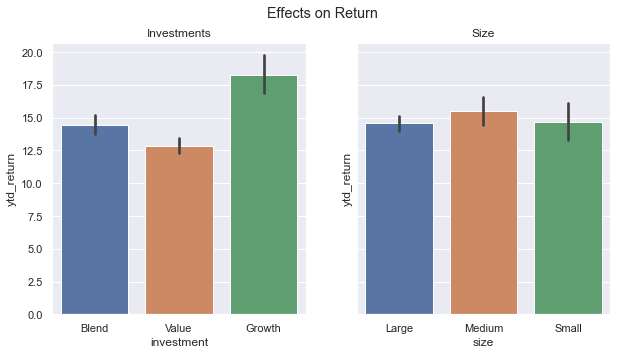

In [72]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,5))
fig.suptitle('Effects on Return')

sns.barplot(ax=axes[0], x='investment', y='ytd_return',data=df_ETF)
axes[0].set_title("Investments")
sns.barplot(ax=axes[1], x='size', y='ytd_return',data=df_ETF)
axes[1].set_title("Size")
plt.show()

#### Based on the graph intutively I'd say combination of growth and medium size will have the maximum probablity of giving us the most return. We need to dig deeper in order to understand if it is even remotely true or not

## Addressing the Null Values

In [73]:
print("There are {} % null values in our dataset" .format(round(((df_ETF.isnull().sum().sum())/(len(df_ETF)*len(df_ETF.columns))*100),0)))

There are 16.0 % null values in our dataset


#### Column wise  missing percentage

In [74]:
percent_missing = df_ETF.isnull().sum() * 100 / len(df_ETF)
missing_value_df = pd.DataFrame({'column_name': df_ETF.columns,
                                 'percent_missing': percent_missing})
missing_value_df=missing_value_df.sort_values(by='percent_missing', ascending= False)
missing_value_df.reset_index(drop =True)[:10]

,column_name,percent_missing
0,fund_return_2010,63.667377
1,fund_return_2011,56.929638
2,category_treynor_ratio_10years,51.769723
3,category_standard_deviation_10years,51.769723
4,category_alpha_10years,51.769723
5,category_beta_10years,51.769723
6,category_r_squared_10years,51.769723
7,category_mean_annual_return_10years,51.769723
8,category_sharpe_ratio_10years,51.769723
9,fund_return_2012,50.788913


Why to see it in tabluar fomrat when we can vizulaize it?!

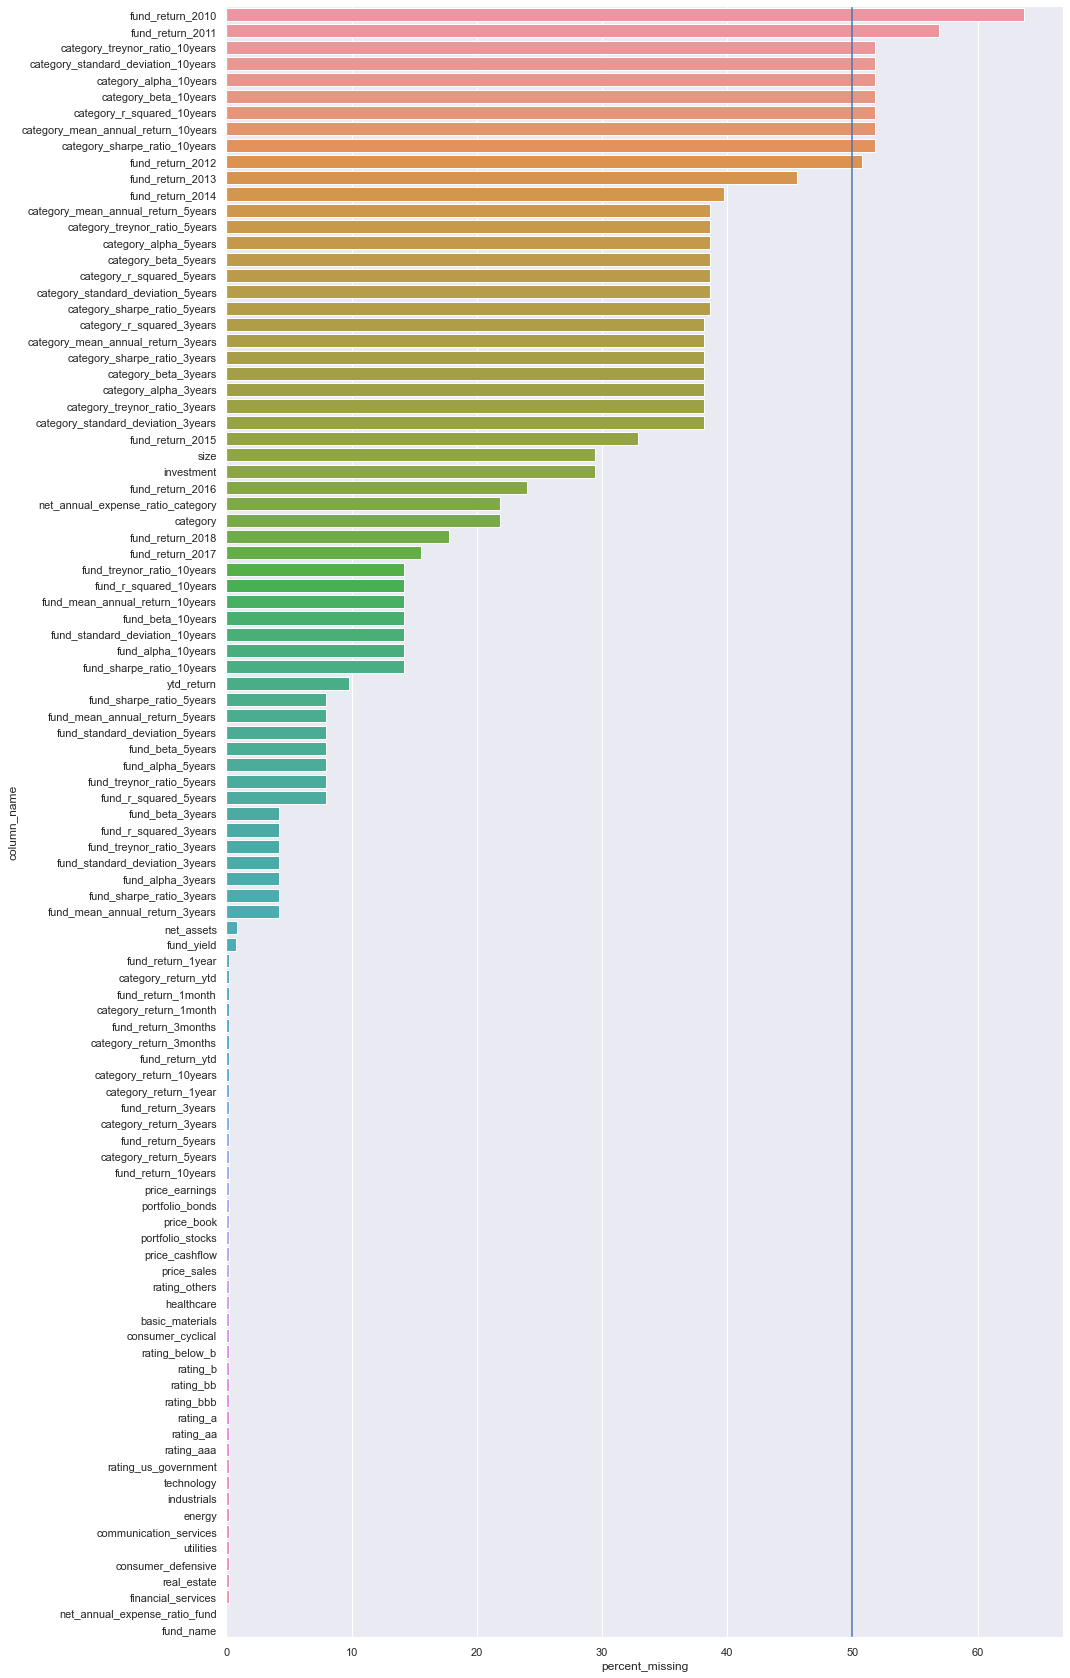

In [75]:
sns.set(rc={'figure.figsize':(15,30)})
graph=sns.barplot(y='column_name',x='percent_missing',data=missing_value_df)
graph.axvline(50)
plt.show()

Keeping columns which have greater than 50% of missing records will increase the noise in the dataset. Threshold line in the above graph gives information about which columns I'm planning to dro.

In [76]:
df_ETF=df_ETF.dropna(thresh=df_ETF.shape[0]*0.5,how='all',axis=1)

### Replacing all the categorical missing valus with string called "missing".

In [77]:
for i in df_ETF.select_dtypes('object').columns:
    print(i,df_ETF[i].nunique())

fund_name 2345
category 95
investment 3
size 3


In [78]:
col=df_ETF.select_dtypes('object').columns[1:]
df_ETF[col]= df_ETF[col].replace(np.nan, "Missing")

In [79]:
print("There are {} % null values in our dataset" .format(round(((df_ETF.isnull().sum().sum())/(len(df_ETF)*len(df_ETF.columns))*100),0)))

There are 10.0 % null values in our dataset


# Imputation

In [80]:
df_num_etf=df_ETF.select_dtypes(float)

#### We will be using KNN Imputer because KNN matches our values with its closest K neighbours. 

In [81]:
from fancyimpute import KNN
imputer = KNN()
encode_data=pd.DataFrame(np.round(imputer.fit_transform(df_num_etf)),columns = df_num_etf.columns)

Imputing row 1/2345 with 17 missing, elapsed time: 2.038
Imputing row 101/2345 with 33 missing, elapsed time: 2.092
Imputing row 201/2345 with 1 missing, elapsed time: 2.119
Imputing row 301/2345 with 23 missing, elapsed time: 2.141
Imputing row 401/2345 with 22 missing, elapsed time: 2.165
Imputing row 501/2345 with 14 missing, elapsed time: 2.185
Imputing row 601/2345 with 3 missing, elapsed time: 2.205
Imputing row 701/2345 with 14 missing, elapsed time: 2.236
Imputing row 801/2345 with 41 missing, elapsed time: 2.259
Imputing row 901/2345 with 0 missing, elapsed time: 2.283
Imputing row 1001/2345 with 0 missing, elapsed time: 2.305
Imputing row 1101/2345 with 17 missing, elapsed time: 2.326
Imputing row 1201/2345 with 1 missing, elapsed time: 2.348
Imputing row 1301/2345 with 0 missing, elapsed time: 2.361
Imputing row 1401/2345 with 17 missing, elapsed time: 2.379
Imputing row 1501/2345 with 3 missing, elapsed time: 2.398
Imputing row 1601/2345 with 0 missing, elapsed time: 2.422


##### Do we still have any null values in our dataset? Lets check.

In [82]:
encode_data.isnull().sum().sum()

0

##### Finally! we have no null values

### Merging back our categorical data with the numerical data

In [83]:
df_encode=pd.merge(left=df_ETF.select_dtypes(object).reset_index(drop=True).reset_index(),
                   right=encode_data.reset_index(),left_on='index',right_on='index',how='left')
df_encode.drop(columns=['index'],inplace=True)

#### After checking the distribution of the data within each column, I found many columns which has highly skewed data.

I am removing those featuers but in future the other option is using transformation techniques (Log/Sqaure root). A glimpse of those columns.

In [84]:
cols=[ 'rating_aaa', 'rating_aa',
       'rating_a', 'rating_bbb']

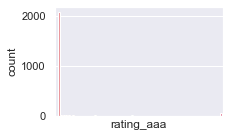

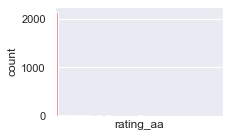

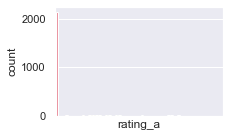

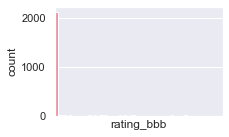

In [85]:
for i, col in enumerate(encode_data[cols]):
    plt.figure(i,figsize=(3, 2))
    sns.countplot(x=col, data=encode_data)
    plt.xticks([])

Dropping all the columns which are skewed like above graphs

In [86]:
drop_cols=['portfolio_bonds','rating_us_government', 'rating_aaa', 'rating_aa',
       'rating_a', 'rating_bbb', 'rating_bb', 'rating_b', 'rating_below_b',
       'rating_others','fund_return_10years','fund_alpha_10years','category_beta_5years', 'fund_beta_10years',
           'fund_r_squared_5years','category_r_squared_5years', 'fund_r_squared_10years','fund_standard_deviation_10years',
           'fund_sharpe_ratio_3years','category_sharpe_ratio_3years', 'fund_sharpe_ratio_5years','category_sharpe_ratio_5years',
           'fund_sharpe_ratio_10years','fund_treynor_ratio_3years', 'category_treynor_ratio_3years','fund_treynor_ratio_5years', 
           'category_treynor_ratio_5years','fund_treynor_ratio_10years','net_assets' ]

In [87]:
df_encode.drop(drop_cols, axis=1, inplace=True)

In [88]:
df_encode.shape

(2345, 61)

Saving our dataframe for future

In [89]:
df=df_encode.copy(deep=True)
df_clean=df.copy(deep=True)

# Clustering

In [90]:
arr_etf=df_encode.values
idx_OUT_columns = [0,1,2,3] #Seperating the Categorical Variables for our model
idx_IN_columns = [i for i in range(np.shape(arr_etf)[1]) if i not in idx_OUT_columns] 
extractedData = arr_etf[:,idx_IN_columns].astype(float)  #Ensuring all float data types
np_arr=np.column_stack((extractedData,df_ETF.select_dtypes(object).values)) #Brining the categorical varaibles back

## K-Protoype clustering

Sice we have a mix of categorical data and numeric data K-Protoype clustering is best alternative

### optimal number of clusters

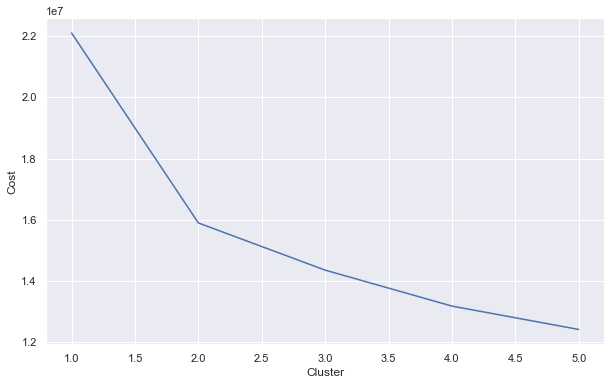

In [91]:
from kmodes.kprototypes import KPrototypes
cost = []
for num_clusters in list(range(1,6)):
    kproto = KPrototypes(n_jobs = -1,n_clusters=num_clusters, init='Cao', random_state=42)
    kproto.fit_predict(np_arr, categorical=[57,58,59,60])
    cost.append(kproto.cost_)
df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cost, x="Cluster", y="Cost")
plt.show()

Based on the above plot there there are 2 optimal clusters

In [92]:
kproto = KPrototypes(n_clusters=2, verbose=5,max_iter=50)
clusters = kproto.fit_predict(np_arr, categorical=[57,58,59,60])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/50, moves: 464, ncost: 19955571.66520681
Run: 1, iteration: 2/50, moves: 356, ncost: 19314795.703216396
Run: 1, iteration: 3/50, moves: 405, ncost: 18297364.259292476
Run: 1, iteration: 4/50, moves: 535, ncost: 16093668.67228091
Run: 1, iteration: 5/50, moves: 141, ncost: 15898964.93241262
Run: 1, iteration: 6/50, moves: 3, ncost: 15898686.270491788
Run: 1, iteration: 7/50, moves: 0, ncost: 15898686.270491788
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/50, moves: 418, ncost: 17359757.91934638
Run: 2, iteration: 2/50, moves: 417, ncost: 15907381.377800478
Run: 2, iteration: 3/50, moves: 30, ncost: 15898862.539629875
Run: 2, iteration: 4/50, moves: 1, ncost: 15898686.270491788
Run: 2, iteration: 5/50, moves: 0, ncost: 15898686.270491788
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration

In [93]:
df_encode['Cluster Labels'] = kproto.labels_
df_encode['Segment'] = df_encode['Cluster Labels'].map({0:'First', 1:'Second'})
df_encode['Segment'] = df_encode['Segment'].astype('category')
df_encode['Segment'] = df_encode['Segment'].cat.reorder_categories(['First','Second'])
df_encode.rename(columns = {'Cluster Labels':'Total'}, inplace = True)

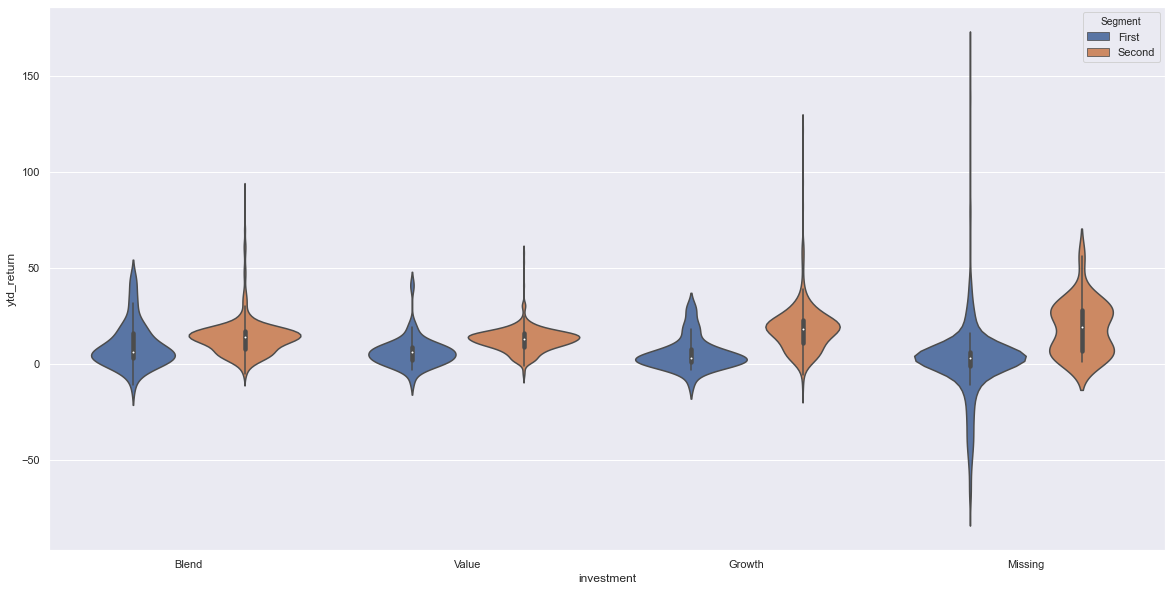

In [95]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
facet = sns.violinplot(data=df_encode,x='investment', y='ytd_return', hue='Segment',
                   fit_reg=False, legend=True, legend_out=True)

#### Based on the above graph we can see the mean of cluster two is always greater than first cluster. Lets try to understand our clusters

In [96]:
df_encode.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df_encode.groupby('Segment').agg(
    {
        'Total':'count',
        'investment': lambda x: x.value_counts().index[0],
        'category': lambda x: x.value_counts().index[0],
        'size': lambda x: x.value_counts().index[0],
        'ytd_return': 'mean',   
    }
).reset_index()

,Segment,Total,investment,category,size,ytd_return
0,First,801,Missing,Missing,Missing,2.604245
1,Second,1544,Blend,Missing,Large,14.575777


Clearly the missing data is overpowering our in our newly created segments. :( 



We will try to analyze the data without the missing categorical values. Also, there is a huge difference in ytd_rertun- Its too good to be true!

Lets create new clusters removing the missing values

## Removing the missing categorical values

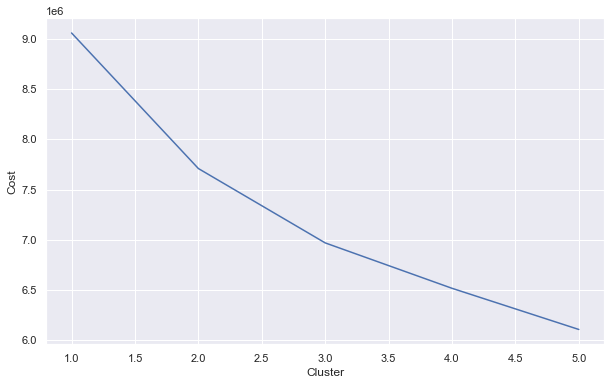

In [97]:
search_values = ['Missing']
cat_list=['category','investment','size']
for col in df_clean[cat_list]:
    df_clean.drop(df_clean[df_clean[col].str.contains('|'.join(search_values ))].index, inplace=True)
    
arr_etf=df_clean.values
idx_OUT_columns = [0,1,2,3] #Seperating the Categorical Variables for our model
idx_IN_columns = [i for i in range(np.shape(arr_etf)[1]) if i not in idx_OUT_columns] 
extractedData = arr_etf[:,idx_IN_columns].astype(float)  #Ensuring all float data types
np_arr=np.column_stack((extractedData,df_clean.select_dtypes(object).values)) #Brining the categorical varaibles back
cost = []
for num_clusters in list(range(1,6)):
    kproto = KPrototypes(n_jobs = -1,n_clusters=num_clusters, init='Cao', random_state=42)
    kproto.fit_predict(np_arr, categorical=[57,58,59,60])
    cost.append(kproto.cost_)
df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cost, x="Cluster", y="Cost")
plt.show()

Now we have 3 optimal clusters

In [98]:
kproto = KPrototypes(n_clusters=3, verbose=5,max_iter=50)
clusters = kproto.fit_predict(np_arr, categorical=[57,58,59,60])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/50, moves: 402, ncost: 7497661.905459267
Run: 1, iteration: 2/50, moves: 115, ncost: 7443861.523031118
Run: 1, iteration: 3/50, moves: 101, ncost: 7352845.267270802
Run: 1, iteration: 4/50, moves: 119, ncost: 7127053.291814819
Run: 1, iteration: 5/50, moves: 66, ncost: 7098747.42484512
Run: 1, iteration: 6/50, moves: 40, ncost: 7078441.733153727
Run: 1, iteration: 7/50, moves: 35, ncost: 7056592.770544582
Run: 1, iteration: 8/50, moves: 21, ncost: 7051379.601377085
Run: 1, iteration: 9/50, moves: 5, ncost: 7050200.201209576
Run: 1, iteration: 10/50, moves: 6, ncost: 7046569.014334712
Run: 1, iteration: 11/50, moves: 26, ncost: 6977662.488017632
Run: 1, iteration: 12/50, moves: 16, ncost: 6972048.689164978
Run: 1, iteration: 13/50, moves: 8, ncost: 6970436.352707589
Run: 1, iteration: 14/50, moves: 0, ncost: 6970436.352707589
Init: initializing centroids
Init: initializing clusters
Start

In [99]:
df_clean['Cluster Labels'] = kproto.labels_
df_clean['Segment'] = df_clean['Cluster Labels'].map({0:'First', 1:'Second', 2:"Third"})

In [100]:
df_clean['Segment'].value_counts()

First     762
Second    415
Third      99
Name: Segment, dtype: int64

In [101]:
df_clean['Segment'] = df_clean['Segment'].astype('category')
df_clean['Segment'] = df_clean['Segment'].cat.reorder_categories(['First','Second','Third'])

In [103]:
df_clean.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df_summary= df_clean.groupby('Segment').agg(
    {
        'Total':'count',
        'investment': lambda x: x.value_counts().index[0],
        'category': lambda x: x.value_counts().index[0],
        'size': lambda x: x.value_counts().index[0],
        'ytd_return': 'mean', 
        'net_annual_expense_ratio_category':'mean',
        'fund_return_1year':'mean',
        'net_annual_expense_ratio_category':'mean',
        'fund_return_2018':'mean',
        'fund_return_2017':'mean',
        'fund_return_2016':'mean',
        'basic_materials':'mean',
        'consumer_cyclical':'mean',
        'financial_services':'mean',
        'real_estate':'mean',
        'consumer_defensive':'mean',
        'healthcare':'mean',
        'utilities':'mean',
        'communication_services':'mean',
        'energy':'mean',
        'industrials':'mean',
        'technology':'mean'
        
    }
).reset_index()

# Insights

In [114]:
df_summary

,Segment,Total,investment,category,size,ytd_return,net_annual_expense_ratio_category,fund_return_1year,fund_return_2018,fund_return_2017,...,consumer_cyclical,financial_services,real_estate,consumer_defensive,healthcare,utilities,communication_services,energy,industrials,technology
0,First,762,Blend,Large Blend,Large,16.942257,0.358268,1.219160,-10.754593,25.476378,...,12.337270,15.120735,5.849081,6.716535,11.628609,4.387139,3.249344,4.821522,12.822835,16.129921
1,Second,415,Blend,Large Blend,Large,13.908434,0.351807,2.390361,-9.339759,17.125301,...,11.301205,17.653012,10.693976,9.221687,8.650602,6.277108,3.363855,4.050602,10.216867,12.838554
2,Third,99,Blend,Natural Resources,Large,15.030303,0.535354,-8.727273,-23.252525,13.393939,...,2.949495,5.282828,0.444444,2.898990,0.424242,2.888889,0.757576,39.868687,3.757576,1.353535


### Lets understand the role of investing in different sectors

In [115]:
df_portfolio=df_summary[['basic_materials', 'consumer_cyclical', 'financial_services',
       'real_estate', 'consumer_defensive', 'healthcare', 'utilities',
       'communication_services', 'energy', 'industrials', 'technology']]

In [116]:
df_portfolio

,basic_materials,consumer_cyclical,financial_services,real_estate,consumer_defensive,healthcare,utilities,communication_services,energy,industrials,technology
0,5.293963,12.337270,15.120735,5.849081,6.716535,11.628609,4.387139,3.249344,4.821522,12.822835,16.129921
1,4.730120,11.301205,17.653012,10.693976,9.221687,8.650602,6.277108,3.363855,4.050602,10.216867,12.838554
2,38.686869,2.949495,5.282828,0.444444,2.898990,0.424242,2.888889,0.757576,39.868687,3.757576,1.353535


### Standardizing the values 

In [117]:
df_portfolio = df_portfolio.div(df_portfolio.sum(axis=1), axis=0).multiply(100)

In [118]:
df_portfolio

,basic_materials,consumer_cyclical,financial_services,real_estate,consumer_defensive,healthcare,utilities,communication_services,energy,industrials,technology
0,5.382398,12.543363,15.373326,5.946790,6.828735,11.822864,4.460426,3.303624,4.902065,13.037039,16.399370
1,4.778016,11.415636,17.831759,10.802259,9.315062,8.738195,6.340668,3.397916,4.091617,10.320319,12.968552
2,38.954434,2.969894,5.319365,0.447518,2.919040,0.427177,2.908869,0.762815,40.144426,3.783564,1.362897


In [119]:
df_portfolio=df_portfolio.T.reset_index()

In [120]:
df_portfolio

,index,0,1,2
0,basic_materials,5.382398,4.778016,38.954434
1,consumer_cyclical,12.543363,11.415636,2.969894
2,financial_services,15.373326,17.831759,5.319365
3,real_estate,5.946790,10.802259,0.447518
4,consumer_defensive,6.828735,9.315062,2.919040
5,healthcare,11.822864,8.738195,0.427177
6,utilities,4.460426,6.340668,2.908869
7,communication_services,3.303624,3.397916,0.762815
8,energy,4.902065,4.091617,40.144426
9,industrials,13.037039,10.320319,3.783564


In [124]:
c = ['firebrick','sandybrown','gold','darkgreen','darkcyan','linen',
         'orange','violet','salmon','aquamarine','grey']
clist1 = {i:j for i, j in zip(df_portfolio['index'].values, c)}
cm = plt.get_cmap('rainbow')
c = [cm(1.0 * i/len(df_portfolio)) for i in range(len(df_portfolio))]
clist2 = {i:j for i, j in zip(df_portfolio['index'].values, c)}

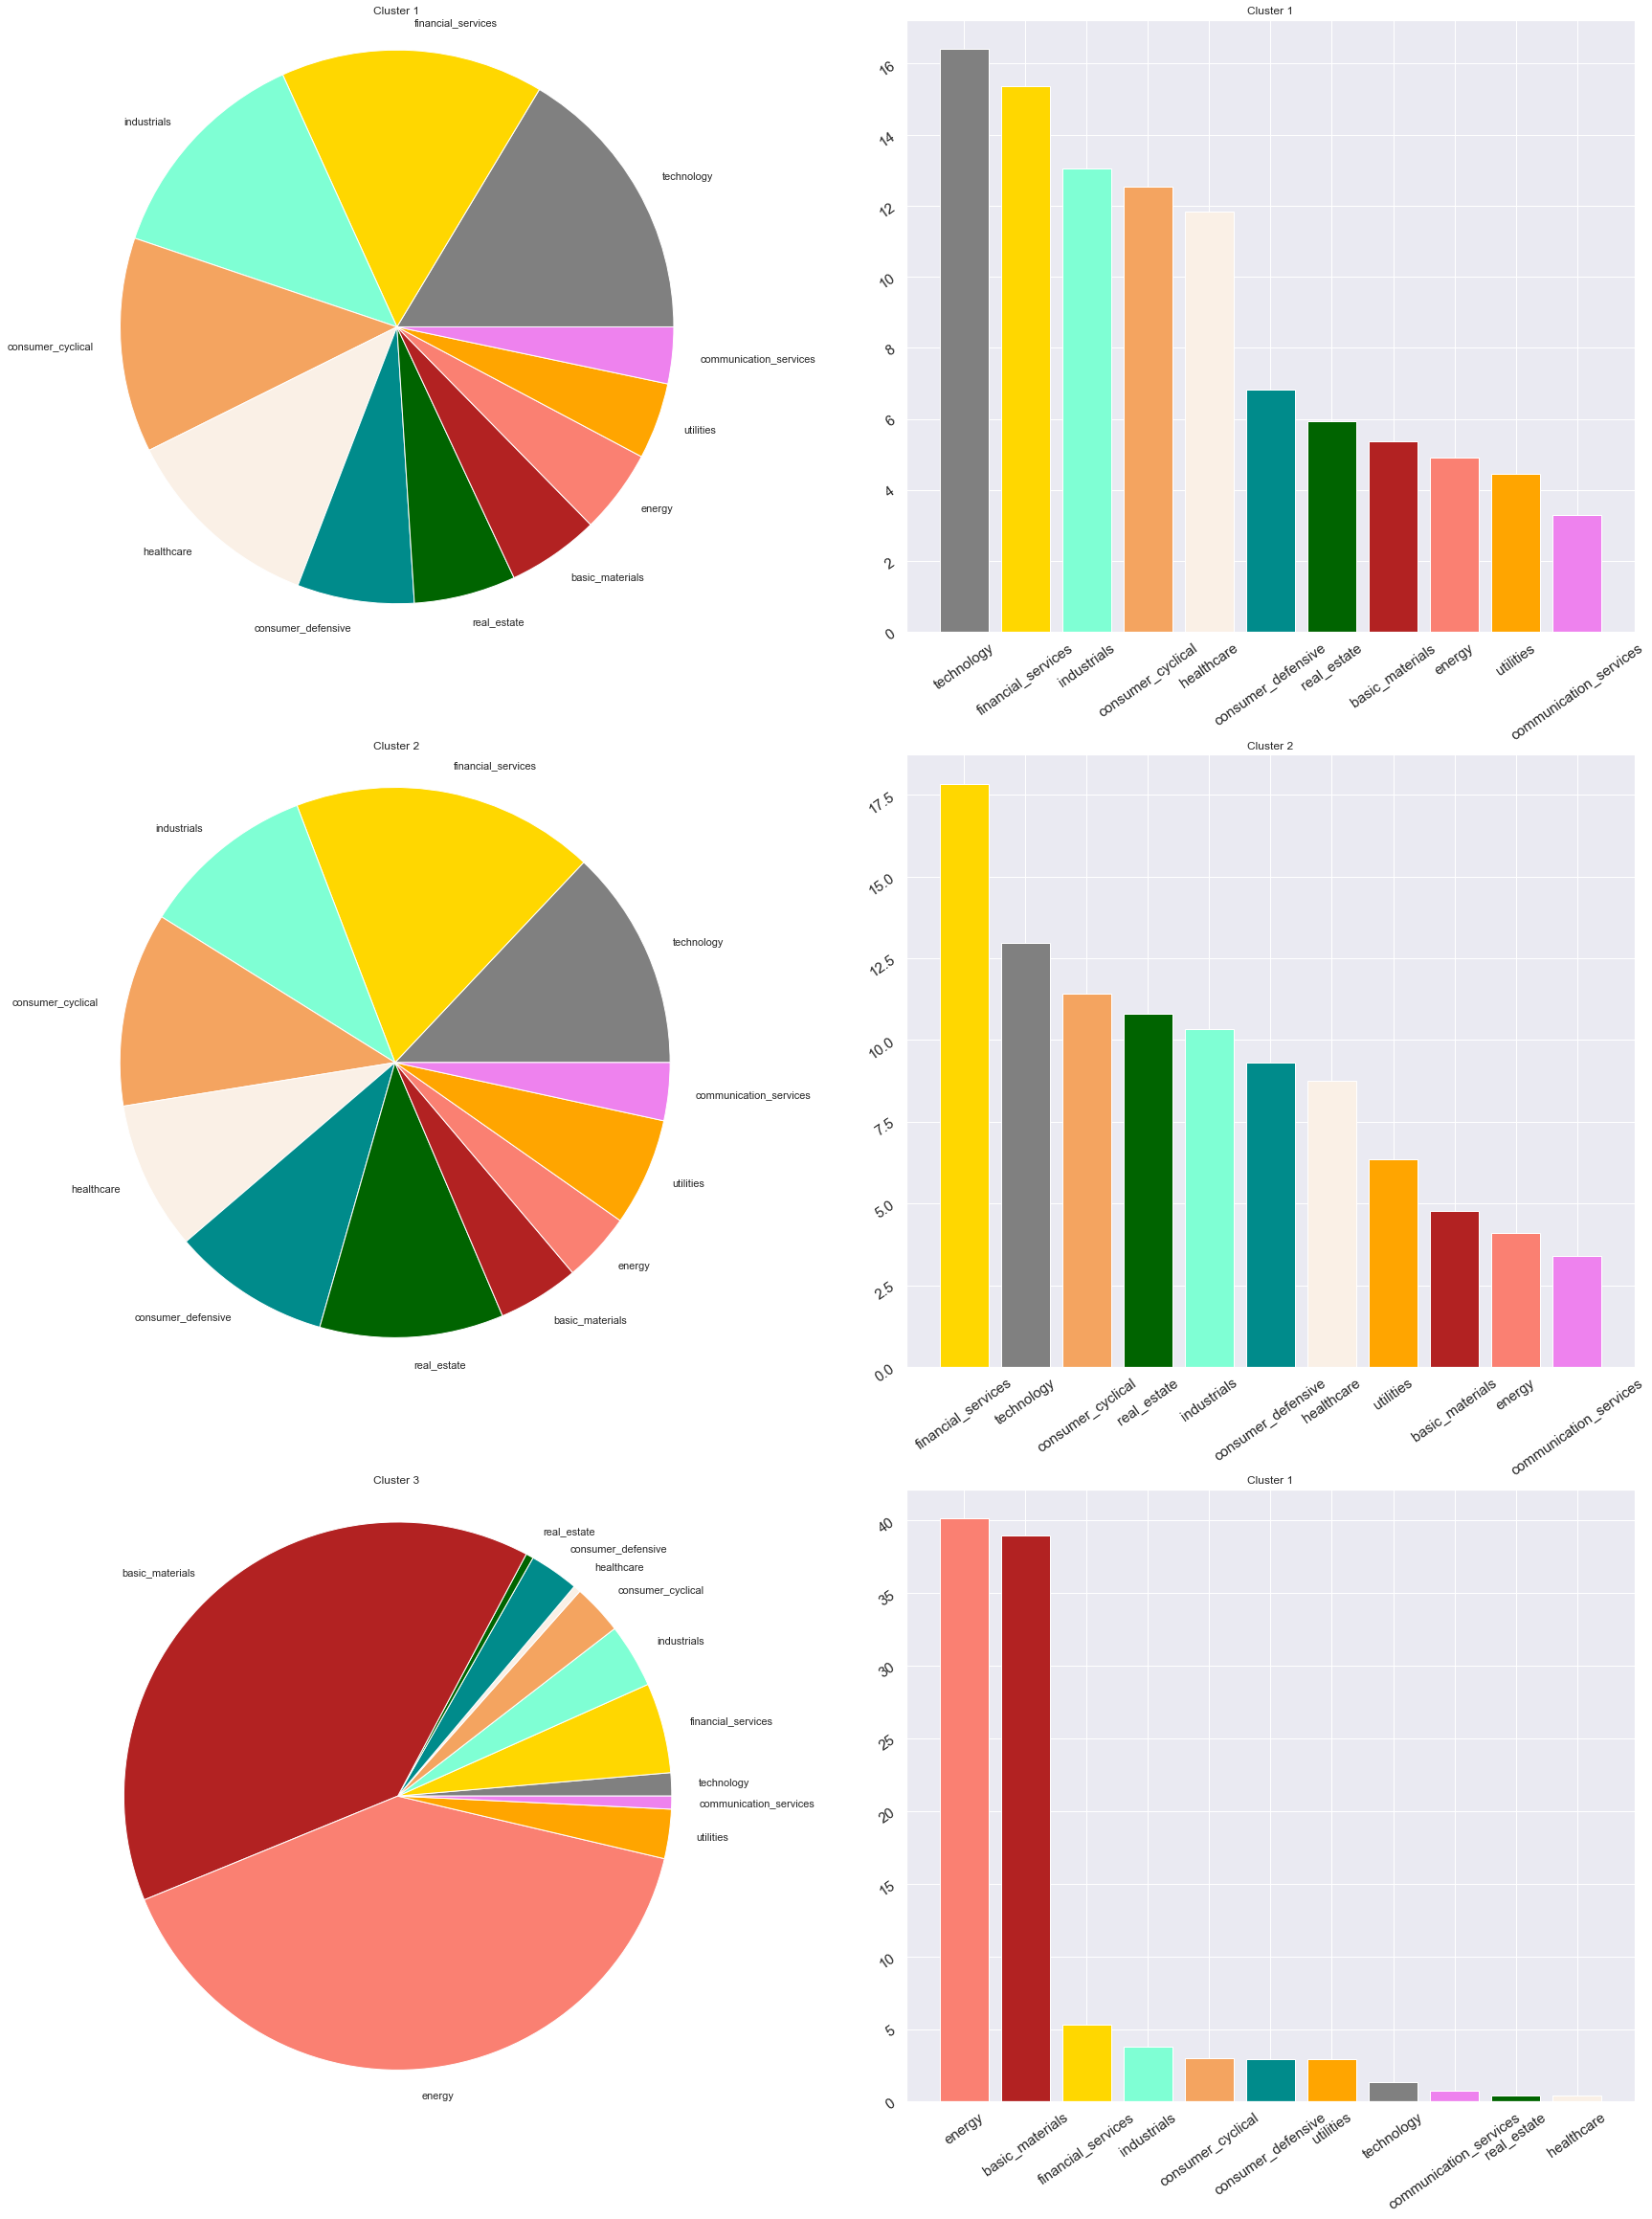

In [125]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 40))

newdf = df_portfolio.sort_values(0, ascending=False)
ax[0, 0].pie(newdf[0], labels=newdf['index'], colors=[clist1[i] for i in newdf['index'].values])
ax[0, 0].axis('square') 
ax[0,0].set_title("Cluster 1")

# BAR PLOT: sort on the second column    
newdf = df_portfolio.sort_values(0, ascending=False)
ax[0, 1].bar(newdf['index'], newdf[0], color=[clist1[i] for i in newdf['index'].values])
ax[0,1].tick_params(labelrotation=35, labelsize=15)
ax[0,1].set_title("Cluster 1")
newdf = df_portfolio.sort_values(0, ascending=False)
ax[1, 0].pie(newdf[1], labels=newdf['index'], colors=[clist1[i] for i in newdf['index'].values])
ax[1, 0].axis('square') 
ax[1,0].set_title("Cluster 2")

# BAR PLOT: sort on the second column    
newdf = df_portfolio.sort_values(1, ascending=False)
ax[1, 1].bar(newdf['index'], newdf[1], color=[clist1[i] for i in newdf['index'].values])
ax[1,1].tick_params(labelrotation=35, labelsize=15)
ax[1,1].set_title("Cluster 2")

newdf = df_portfolio.sort_values(0, ascending=False)
ax[2, 0].pie(newdf[2], labels=newdf['index'], colors=[clist1[i] for i in newdf['index'].values])
ax[2, 0].axis('square') 
ax[2,0].set_title("Cluster 3")

# BAR PLOT: sort on the second column    
newdf = df_portfolio.sort_values(2, ascending=False)
ax[2, 1].bar(newdf['index'], newdf[2], color=[clist1[i] for i in newdf['index'].values])
ax[2,1].tick_params(labelrotation=35, labelsize=15)
ax[2,1].set_title("Cluster 1")
plt.savefig('Portfolio.png')
plt.show()

In [140]:
df_summary.iloc[:,:7]

,Segment,Total,investment,category,size,ytd_return,net_annual_expense_ratio_category
0,First,762,Blend,Large Blend,Large,16.942257,0.358268
1,Second,415,Blend,Large Blend,Large,13.908434,0.351807
2,Third,99,Blend,Natural Resources,Large,15.030303,0.535354
